In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import glob
import missingno as msno
import matplotlib.pyplot as plt
import dill as pickle
import warnings

from datetime import date, datetime, time
from os.path import dirname, exists
from tqdm import tqdm
from time import perf_counter, sleep
from humanfriendly import format_timespan
from pandas.api.types import is_numeric_dtype  
tqdm.pandas()

from sklearn import linear_model
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")  # Suppress all warnings
plt.style.use('ggplot')
pd.set_option('display.max_rows', 1000000)

In [2]:
if exists('dataset_SCL.csv'):
    dataset = pd.read_csv('dataset_SCL.csv', sep = ",", decimal = ".", na_values = "NA", encoding='utf8', low_memory = False)

dataset['Fecha-I'] = pd.to_datetime(dataset['Fecha-I'])
dataset['Fecha-O'] = pd.to_datetime(dataset['Fecha-O'])
dataset.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [3]:
print(" \nDataset shape: \n\n", 
      dataset.shape)
print(" \nCount total NaN at each column in the dataset : \n\n", 
      dataset.isnull().sum()) 

 
Dataset shape: 

 (68206, 18)
 
Count total NaN at each column in the dataset : 

 Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64


**Limpieza de Datos**

In [4]:
print("Información Dataset")
dataset.info()

Información Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68206 non-null  object        
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68205 non-null  object        
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int64         
 11  MES        68206 non-null  int64         
 12  AÑO        68206 non-null  int64         
 13  DIANOM     68206 non-null  object        
 14  TIPOVUELO  68206 non-null  object        
 15  OPERA      68206 non-null  object        
 16  SIGLAORI   68206 non

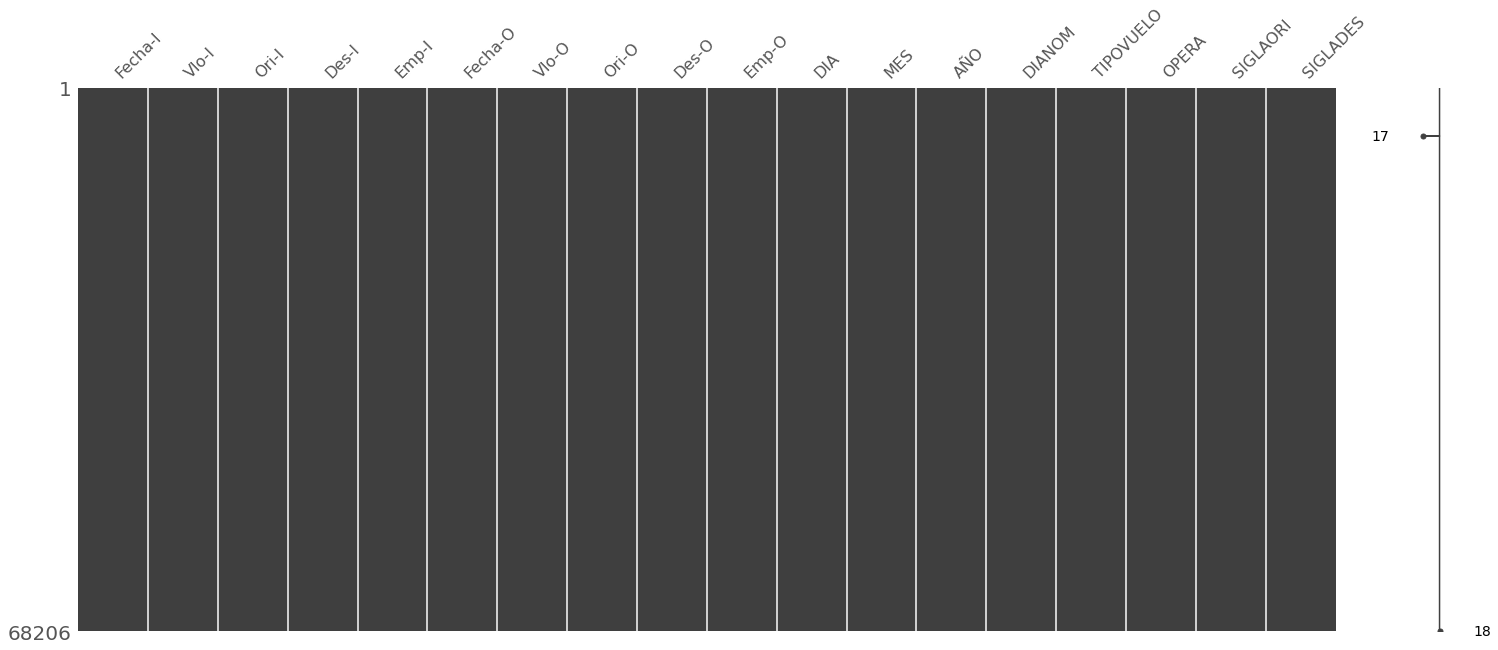

In [5]:
if dataset.isnull().values.any():
    msno.matrix(dataset)

In [6]:
dataset.dropna(inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68205 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68205 non-null  datetime64[ns]
 1   Vlo-I      68205 non-null  object        
 2   Ori-I      68205 non-null  object        
 3   Des-I      68205 non-null  object        
 4   Emp-I      68205 non-null  object        
 5   Fecha-O    68205 non-null  datetime64[ns]
 6   Vlo-O      68205 non-null  object        
 7   Ori-O      68205 non-null  object        
 8   Des-O      68205 non-null  object        
 9   Emp-O      68205 non-null  object        
 10  DIA        68205 non-null  int64         
 11  MES        68205 non-null  int64         
 12  AÑO        68205 non-null  int64         
 13  DIANOM     68205 non-null  object        
 14  TIPOVUELO  68205 non-null  object        
 15  OPERA      68205 non-null  object        
 16  SIGLAORI   68205 non-null  object       

In [7]:
def histogramgraph(data):
    fig = plt.figure(figsize = (20,15))
    ax = fig.gca()
    data.hist(ax = ax, alpha=0.7)

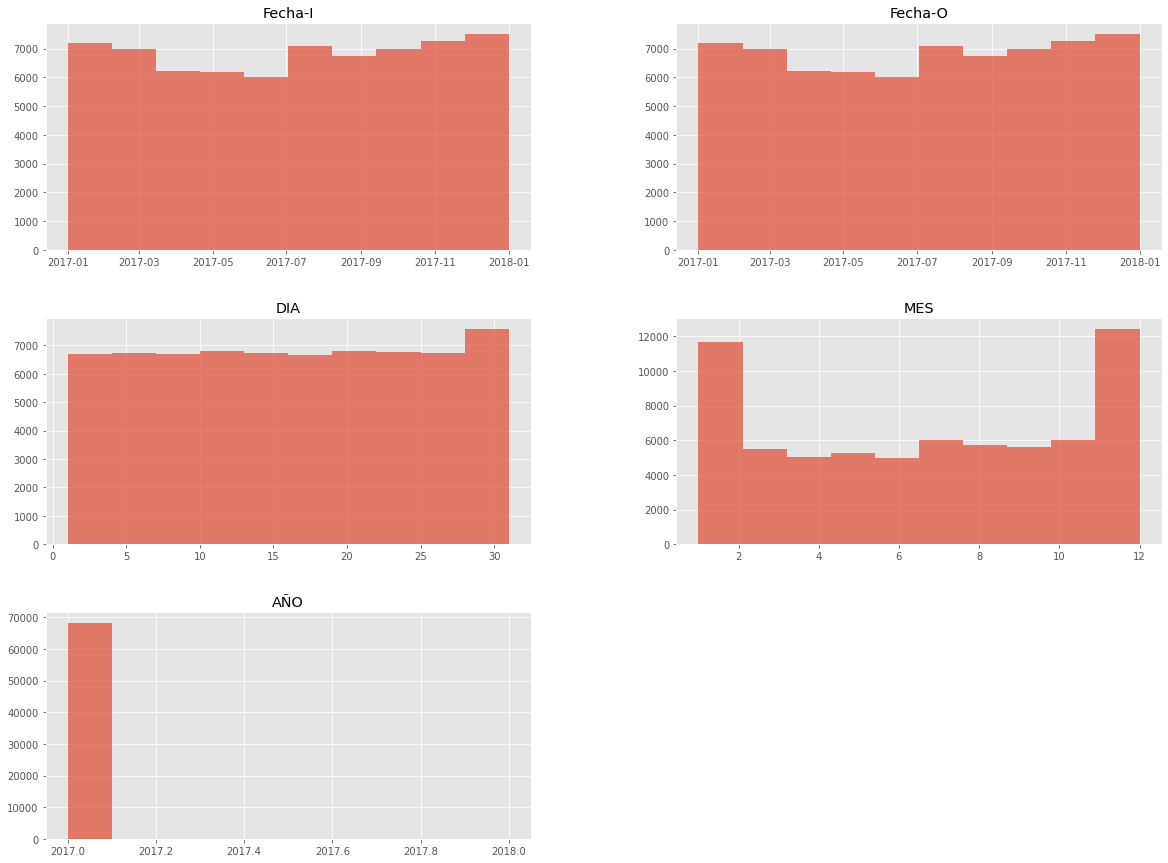

In [8]:
histogramgraph(dataset)

In [9]:
def boxplot(data):
    data.plot.box(figsize = (15, 10), rot = 90, grid = True)

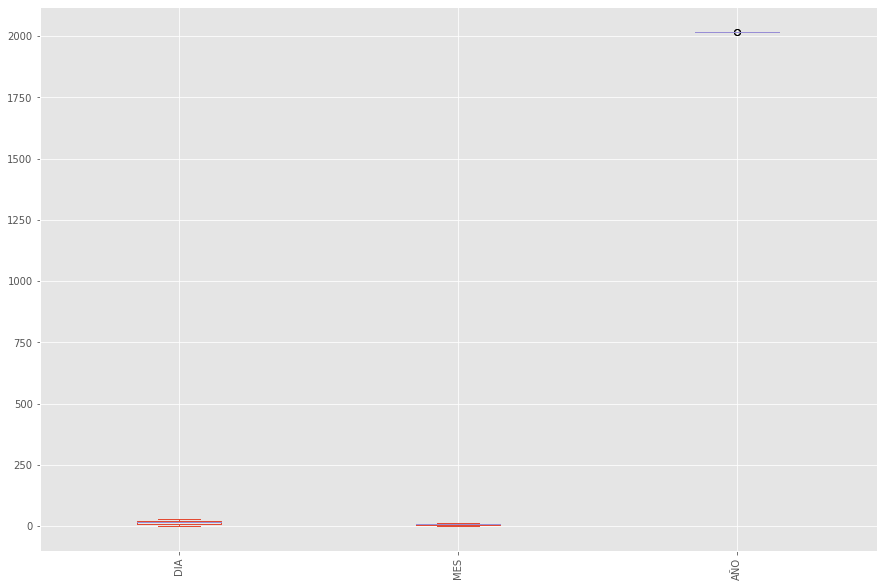

In [10]:
boxplot(dataset)

In [11]:
def correlationgraph(data):
    f = plt.figure(figsize=(19, 15))
    plt.matshow(data.corr(), fignum=f.number)
    plt.rcParams.update({'font.size': 14})
    for (i, j), z in np.ndenumerate(data.corr()):
        plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    plt.xticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=14, rotation=45)
    plt.yticks(range(data.select_dtypes(['number']).shape[1]), data.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);

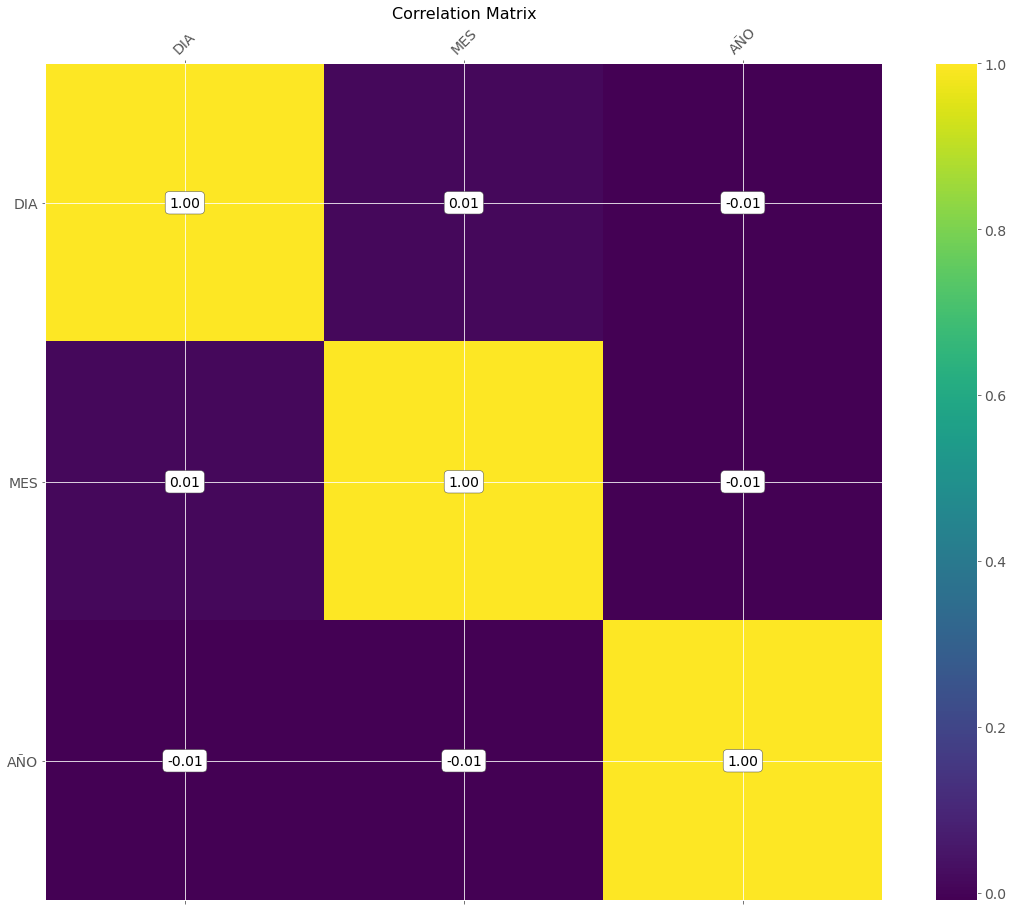

In [12]:
correlationgraph(dataset)

**Generando archivo synthetic_features.csv**

In [13]:
def temporadas(row):
    datetime_obj = datetime.strptime(str(row), '%Y-%m-%d %H:%M:%S')
    my_date = datetime_obj.date()
    
    boundarydict = {"Si": [(date(my_date.year, 12, 15), date(my_date.year, 12, 31)),
                           (date(my_date.year, 1, 1), date(my_date.year, 3, 3)),
                           (date(my_date.year, 7, 15), date(my_date.year, 7, 31)),
                           (date(my_date.year, 9, 11), date(my_date.year, 9, 30))],
                    "No": [(date(my_date.year, 3, 4), date(my_date.year, 7, 14)),
                           (date(my_date.year, 8, 1), date(my_date.year, 9, 10)),
                           (date(my_date.year, 12, 1), date(my_date.year, 12, 14))]}
    
    for retval, boundaries in boundarydict.items():
        if any(a <= my_date <= b for a, b in boundaries):
            return retval

In [14]:
def periodo(row):
    datetime_obj = datetime.strptime(str(row), '%Y-%m-%d %H:%M:%S')
    my_time = datetime_obj.time()
    
    boundarydict = {"mañana": [(time(5, 0), time(11, 59))],
                    "tarde": [(time(12, 0), time(18, 59))],
                    "noche": [(time(19, 0), time(23, 59)),
                              (time(0, 0), time(4, 59))]}
    
    for retval, boundaries in boundarydict.items():
        if any(a <= my_time <= b for a, b in boundaries):
            return retval

In [15]:
synthetic_features = pd.DataFrame(columns=['temporada_alta', 'dif_min', 'atraso_15', 'periodo_dia'], 
                                  index = dataset.index)

In [16]:
synthetic_features['temporada_alta'] = dataset['Fecha-I'].progress_apply(temporadas)

100%|█████████████████████████████████████████████████████████████████████████| 68205/68205 [00:01<00:00, 40081.46it/s]


In [17]:
synthetic_features['dif_min'] = dataset['Fecha-O'] - dataset['Fecha-I']
synthetic_features['dif_min'] = synthetic_features['dif_min'] / np.timedelta64(1,'m')
synthetic_features['dif_min'][synthetic_features['dif_min'] < 0] = 0

In [18]:
synthetic_features['atraso_15'] = synthetic_features['dif_min'].progress_apply(lambda x: 1 if x > 15.0 else 0)

100%|████████████████████████████████████████████████████████████████████████| 68205/68205 [00:00<00:00, 710476.13it/s]


In [19]:
synthetic_features['periodo_dia'] = dataset['Fecha-I'].progress_apply(periodo)

100%|█████████████████████████████████████████████████████████████████████████| 68205/68205 [00:01<00:00, 42468.02it/s]


In [20]:
synthetic_features.to_csv("synthetic_features.csv", sep=',', decimal = ".", encoding='utf-8', index=False)

**Tasa de atraso**

A continuación observamos la tasas de retraso usando como variables de medición distintos atributos del conjunto de datos. Se puede ver que....

Con base a esto esperamos que las variables de... sean las de mayor aporte al momento de predecir retrasos.

In [21]:
def tasadeatraso(df, col, filas, decimales):
    print(round(df.groupby([col])[col].count()/filas, decimales))

In [22]:
atraso_synthetic_features = synthetic_features.loc[synthetic_features['atraso_15'] == 1]
atraso_dataset = dataset.loc[atraso_synthetic_features.index, :]

In [23]:
print("tasa de atraso/destino origen")
tasadeatraso(df = atraso_dataset, col = 'Des-I', 
             filas = dataset.shape[0], decimales = 3)

tasa de atraso/destino origen
Des-I
CYYZ    0.001
EGLL    0.000
EGYP    0.000
KATL    0.000
KDFW    0.000
KIAH    0.000
KJFK    0.001
KLAX    0.001
KMCO    0.000
KMIA    0.003
LEMD    0.002
LFPG    0.000
LIRF    0.000
MDPC    0.000
MMMX    0.001
MMUN    0.000
MPTO    0.002
NZAA    0.002
SAAR    0.001
SABE    0.012
SACO    0.005
SAEZ    0.012
SAME    0.006
SANT    0.000
SANU    0.000
SAWH    0.000
SAZN    0.000
SAZS    0.000
SBFL    0.000
SBGL    0.006
SBGR    0.013
SCAR    0.005
SCAT    0.004
SCBA    0.002
SCCF    0.009
SCCI    0.005
SCDA    0.009
SCFA    0.012
SCIE    0.009
SCIP    0.001
SCJO    0.001
SCNT    0.000
SCPQ    0.000
SCQP    0.006
SCSE    0.006
SCTE    0.011
SCVD    0.002
SEGU    0.001
SEQM    0.000
SEQU    0.000
SGAS    0.001
SKBO    0.006
SLCB    0.000
SLLP    0.000
SLVR    0.000
SPJC    0.018
SULS    0.000
SUMU    0.003
YMML    0.000
YSSY    0.002
Name: Des-I, dtype: float64


In [24]:
print("tasa de atraso/destino operación")
tasadeatraso(df = atraso_dataset, col = 'Des-O', 
             filas = dataset.shape[0], decimales = 3)

tasa de atraso/destino operación
Des-O
CYYZ    0.001
EGLL    0.000
EGYP    0.000
KATL    0.000
KDFW    0.000
KIAH    0.000
KJFK    0.001
KLAX    0.001
KMCO    0.000
KMIA    0.003
LEMD    0.002
LFPG    0.000
LIRF    0.000
MDPC    0.000
MMMX    0.001
MMUN    0.000
MPTO    0.002
NZAA    0.002
SAAR    0.001
SABE    0.012
SACO    0.005
SAEZ    0.012
SAME    0.006
SANT    0.000
SANU    0.000
SAWH    0.000
SAZN    0.000
SAZS    0.000
SBFL    0.000
SBGL    0.006
SBGR    0.013
SCAR    0.005
SCAT    0.004
SCBA    0.002
SCCF    0.009
SCCI    0.005
SCDA    0.009
SCFA    0.012
SCIE    0.009
SCIP    0.001
SCJO    0.001
SCNT    0.000
SCPQ    0.000
SCQP    0.006
SCSE    0.006
SCTE    0.011
SCVD    0.002
SEGU    0.001
SEQM    0.000
SGAS    0.001
SKBO    0.006
SLCB    0.000
SLLP    0.000
SLVR    0.000
SPJC    0.018
SULS    0.000
SUMU    0.003
YMML    0.000
YSSY    0.002
Name: Des-O, dtype: float64


In [25]:
print("tasa de atraso/aerolinea")
tasadeatraso(df = atraso_dataset, col = 'OPERA', 
             filas = dataset.shape[0], decimales = 3)

tasa de atraso/aerolinea
OPERA
Aerolineas Argentinas       0.007
Aeromexico                  0.000
Air Canada                  0.004
Air France                  0.000
Alitalia                    0.000
American Airlines           0.001
Austral                     0.000
Avianca                     0.004
British Airways             0.000
Copa Air                    0.002
Delta Air                   0.000
Gol Trans                   0.004
Grupo LATAM                 0.107
Iberia                      0.001
JetSmart SPA                0.003
K.L.M.                      0.000
Lacsa                       0.000
Latin American Wings        0.010
Oceanair Linhas Aereas      0.001
Plus Ultra Lineas Aereas    0.000
Qantas Airways              0.002
Sky Airline                 0.037
United Airlines             0.000
Name: OPERA, dtype: float64


In [26]:
print("tasa de atraso/mes")
tasadeatraso(df = atraso_dataset, col = 'MES', 
             filas = dataset.shape[0], decimales = 3)

tasa de atraso/mes
MES
1     0.014
2     0.012
3     0.009
4     0.009
5     0.012
6     0.012
7     0.026
8     0.015
9     0.014
10    0.020
11    0.018
12    0.024
Name: MES, dtype: float64


In [27]:
print("tasa de atraso/día")
tasadeatraso(df = atraso_dataset, col = 'DIANOM', 
             filas = dataset.shape[0], decimales = 3)

tasa de atraso/día
DIANOM
Domingo      0.023
Jueves       0.030
Lunes        0.030
Martes       0.024
Miercoles    0.024
Sabado       0.020
Viernes      0.034
Name: DIANOM, dtype: float64


In [28]:
print("tasa de atraso/tipo de vuelo")
tasadeatraso(df = atraso_dataset, col = 'TIPOVUELO', 
             filas = dataset.shape[0], decimales = 3)

tasa de atraso/tipo de vuelo
TIPOVUELO
I    0.103
N    0.082
Name: TIPOVUELO, dtype: float64


In [29]:
print("tasa de atraso/temporada")
tasadeatraso(df = atraso_synthetic_features, col = 'temporada_alta', 
             filas = synthetic_features.shape[0], decimales = 3)

tasa de atraso/temporada
temporada_alta
No    0.082
Si    0.066
Name: temporada_alta, dtype: float64


**Generación Algoritmo de Predicción**

Categorizamos las variables no numericas

In [30]:
def convert_cats(df):
    cats = []
    for col in df.columns:
        if is_numeric_dtype(df[col]) or "Fecha" in col:
            pass
        else:
            cats.append(col)
            
    for col in cats:
        df[col] = df[col].astype('category').cat.codes
    return df

In [31]:
def delete_highly_correlated(data, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = data.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in data.columns:
                    del data[colname] # deleting the column from the data
    return data

In [32]:
def probatraso(row):
    atraso = round((row.dif_min * 100 / 15), 3)
    if atraso >= 100.000:
        return 100.000
    else:
        return atraso

In [33]:
def savemodel(model, name, verbose):
    if verbose:
        print("Saving model:", name)
    if not os.path.isdir('Models'):
        os.mkdir("Models")
    with open(name, 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

In [34]:
def modelraining(data, modelos, verbose):
    startf = perf_counter()
    X = data.drop("Probabilidad_Atraso", axis = 1)
    y = data['Probabilidad_Atraso']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
        
    for modelo in modelos:
        clase = 1
        if modelo == "linear":
            model = linear_model.LinearRegression()
        elif modelo == "Ridge":
            model = linear_model.Ridge(alpha=.5)
        elif modelo == "Lasso":
            model = linear_model.Lasso(alpha=.1)
        elif modelo == "BayesianRidge":
            model = linear_model.BayesianRidge()
        elif modelo == "SVM":
            model = svm.SVR()
        elif modelo == "Tree":
            model = tree.DecisionTreeRegressor()
        elif modelo == "RF":
            model = RandomForestRegressor(random_state=1)
        elif modelo == "GBR":
            model = GradientBoostingRegressor(random_state=1)
        elif modelo == "VR":
            reg1 = GradientBoostingRegressor(random_state=1)
            reg2 = RandomForestRegressor(random_state=1)
            reg3 = linear_model.LinearRegression()
            model = VotingRegressor(estimators=[('GBR', reg1), ('RF', reg2), ('linear', reg3)])
        elif modelo == "KNN":
            model = KNeighborsRegressor(n_neighbors=20, metric='euclidean')
        elif modelo == "MLP":
            model = MLPRegressor(random_state=1, max_iter=500)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
            
        if verbose:
            print(modelo + " r2_score:",metrics.r2_score(y_test, y_pred))
            print(modelo + " MAE:",metrics.mean_absolute_error(y_test, y_pred))
            print(modelo + " MSE:",metrics.mean_squared_error(y_test, y_pred))
            print(modelo + " MSLE:",metrics.mean_squared_log_error(y_test, y_pred))
            print(modelo + " MAPE:",metrics.mean_absolute_percentage_error(y_test, y_pred))
            print(modelo + " MedAE:",metrics.median_absolute_error(y_test, y_pred))
            print(modelo + " Max Error:",metrics.max_error(y_test, y_pred))
            print(modelo + " EVS:",metrics.explained_variance_score(y_test, y_pred))
        
        savemodel(model, "Models/"+ modelo +"_PrData.pkl", verbose)
        if verbose:
            print("-----------------------------------------------------------------------------")
            print("")
        
    if verbose == True:
        print("--Took", format_timespan(perf_counter() - startf), "to process the file with the selected models.")
        print("-----------------------------------------------------------------------------")
        print("")

In [35]:
dataset2 = convert_cats(dataset.copy())
dataset2.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,219,0,9,0,2017-01-01 23:33:00,318,0,10,2,1,1,2017,0,0,5,0,34
1,2017-01-02 23:30:00,219,0,9,0,2017-01-02 23:39:00,318,0,10,2,2,1,2017,2,0,5,0,34
2,2017-01-03 23:30:00,219,0,9,0,2017-01-03 23:39:00,318,0,10,2,3,1,2017,3,0,5,0,34
3,2017-01-04 23:30:00,219,0,9,0,2017-01-04 23:33:00,318,0,10,2,4,1,2017,4,0,5,0,34
4,2017-01-05 23:30:00,219,0,9,0,2017-01-05 23:28:00,318,0,10,2,5,1,2017,1,0,5,0,34


In [36]:
synthetic_features2 = convert_cats(synthetic_features.copy())
synthetic_features2.head()

,temporada_alta,dif_min,atraso_15,periodo_dia
0,1,3.0,0,1
1,1,9.0,0,1
2,1,9.0,0,1
3,1,3.0,0,1
4,1,0.0,0,1


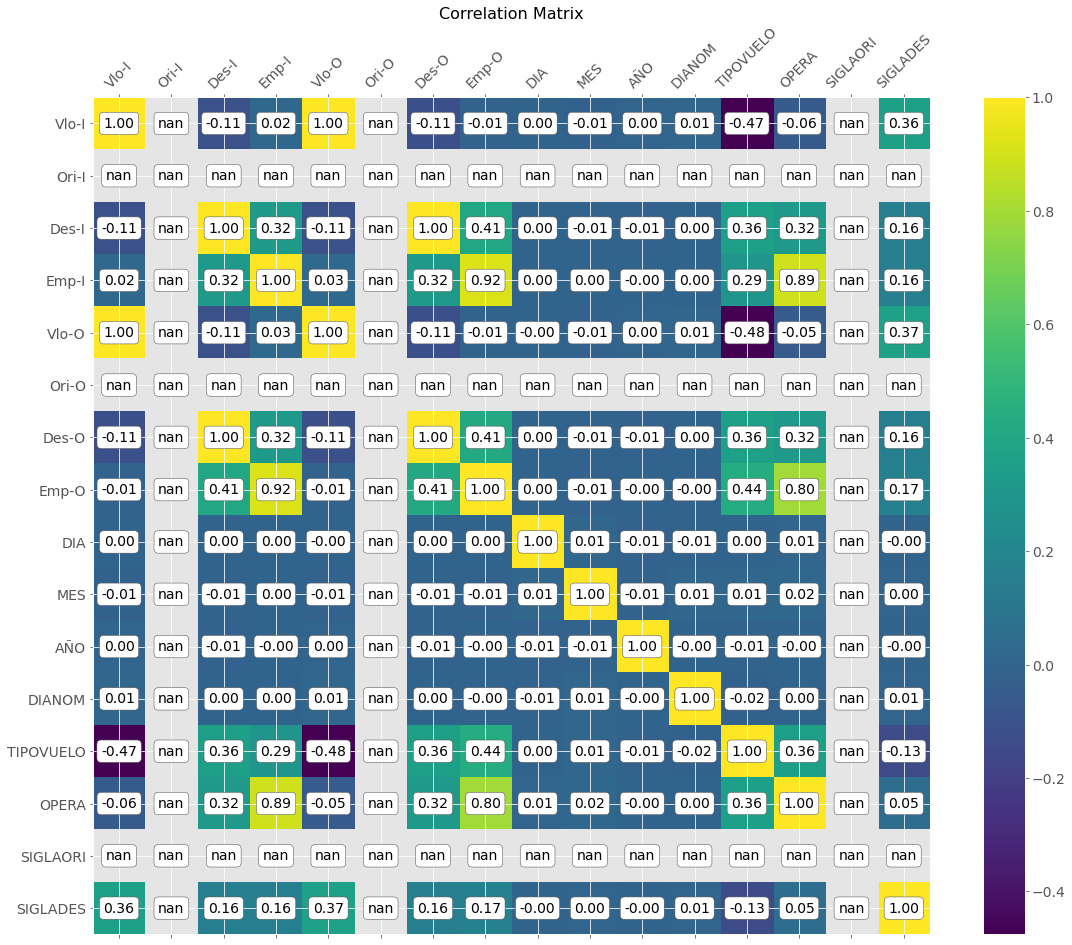

In [37]:
correlationgraph(dataset2)

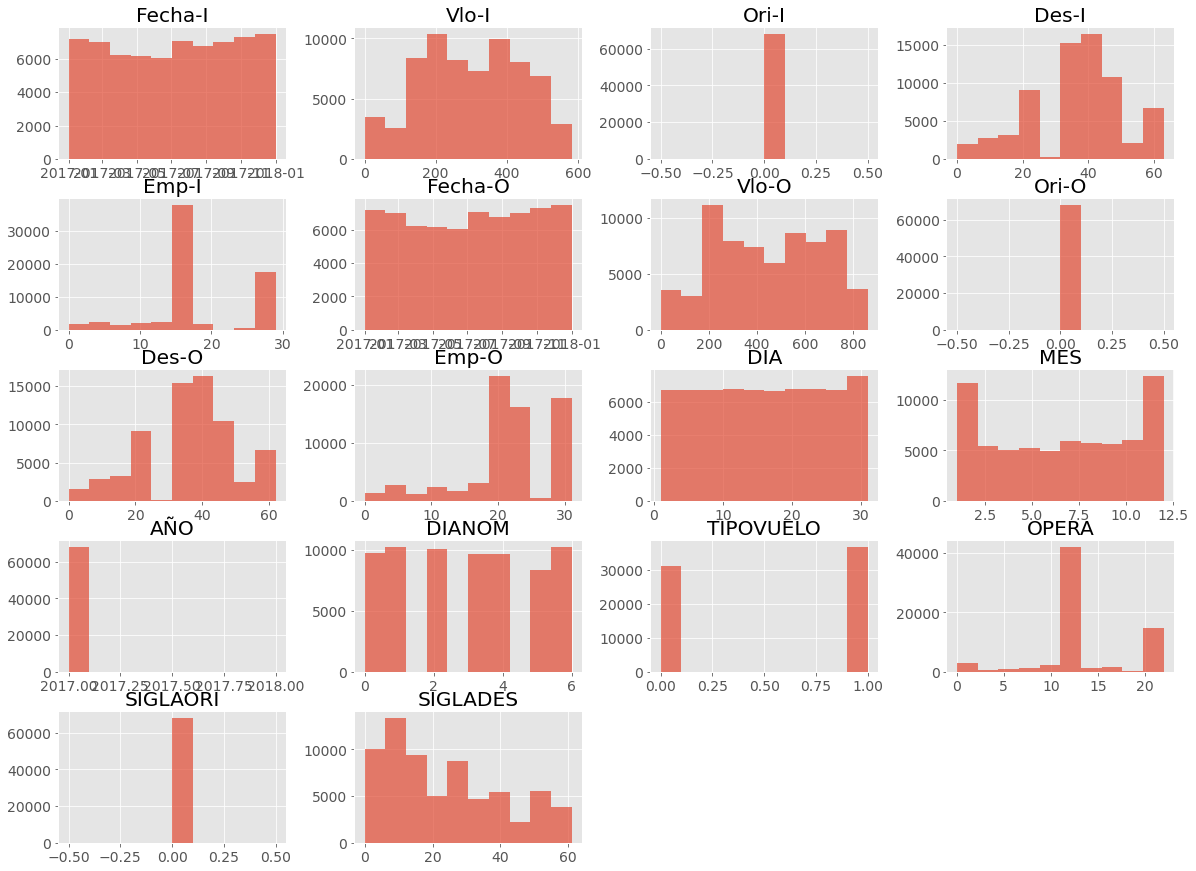

In [38]:
histogramgraph(dataset2)

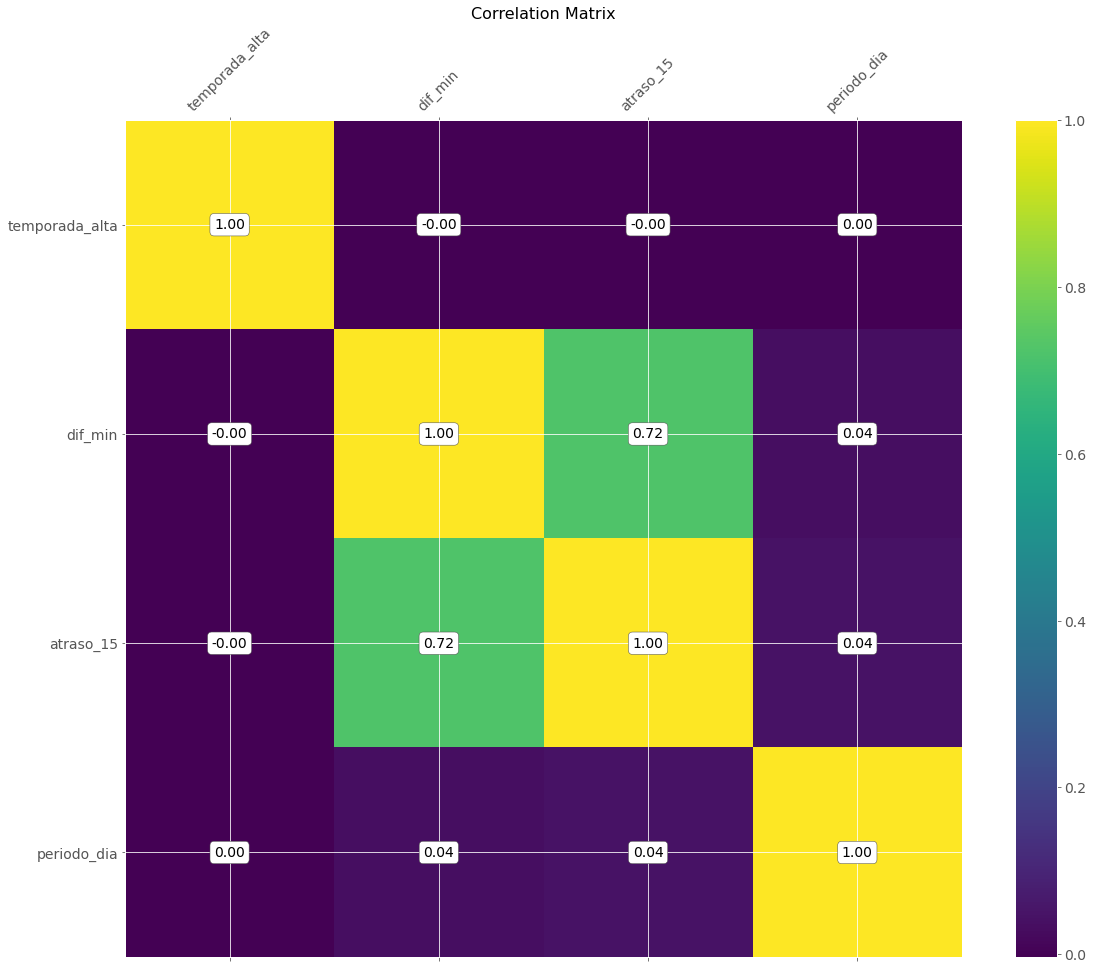

In [39]:
correlationgraph(synthetic_features2)

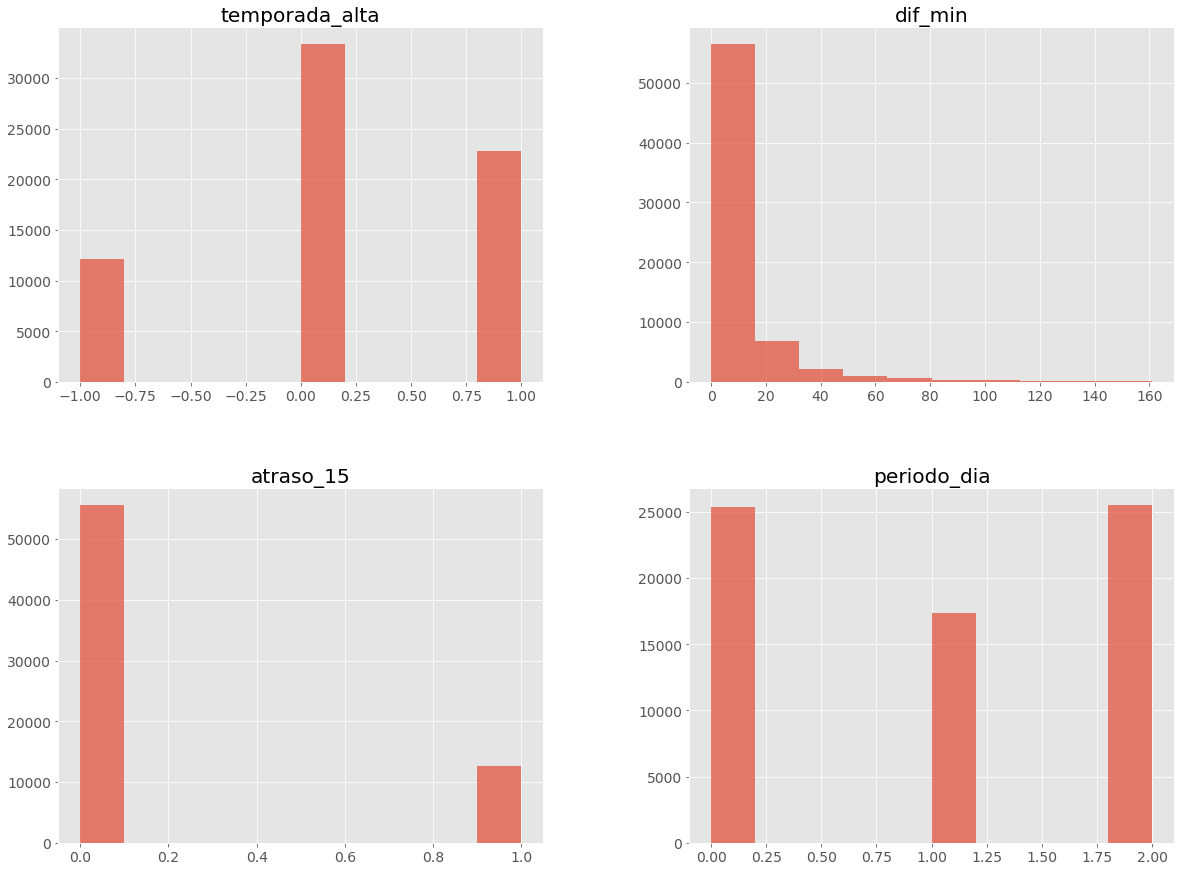

In [40]:
histogramgraph(synthetic_features2)

In [41]:
allDataset = pd.concat([dataset2, synthetic_features2], axis=1)
allDataset.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,temporada_alta,dif_min,atraso_15,periodo_dia
0,2017-01-01 23:30:00,219,0,9,0,2017-01-01 23:33:00,318,0,10,2,...,2017,0,0,5,0,34,1,3.0,0,1
1,2017-01-02 23:30:00,219,0,9,0,2017-01-02 23:39:00,318,0,10,2,...,2017,2,0,5,0,34,1,9.0,0,1
2,2017-01-03 23:30:00,219,0,9,0,2017-01-03 23:39:00,318,0,10,2,...,2017,3,0,5,0,34,1,9.0,0,1
3,2017-01-04 23:30:00,219,0,9,0,2017-01-04 23:33:00,318,0,10,2,...,2017,4,0,5,0,34,1,3.0,0,1
4,2017-01-05 23:30:00,219,0,9,0,2017-01-05 23:28:00,318,0,10,2,...,2017,1,0,5,0,34,1,0.0,0,1


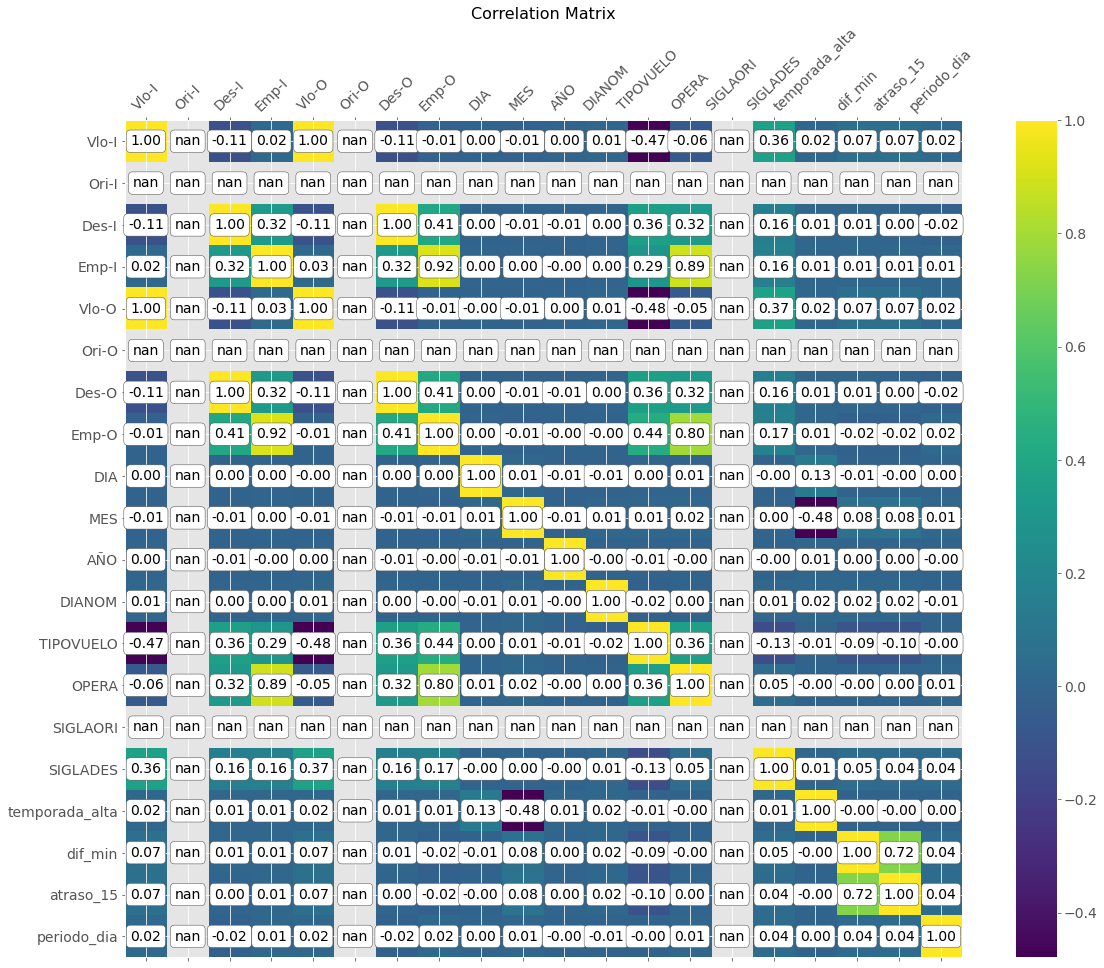

In [42]:
correlationgraph(allDataset)

In [43]:
allDataset.drop('Fecha-I', axis=1, inplace=True)
allDataset.drop('Fecha-O', axis=1, inplace=True)

In [44]:
allDataset = delete_highly_correlated(data = allDataset, threshold = 0.8)

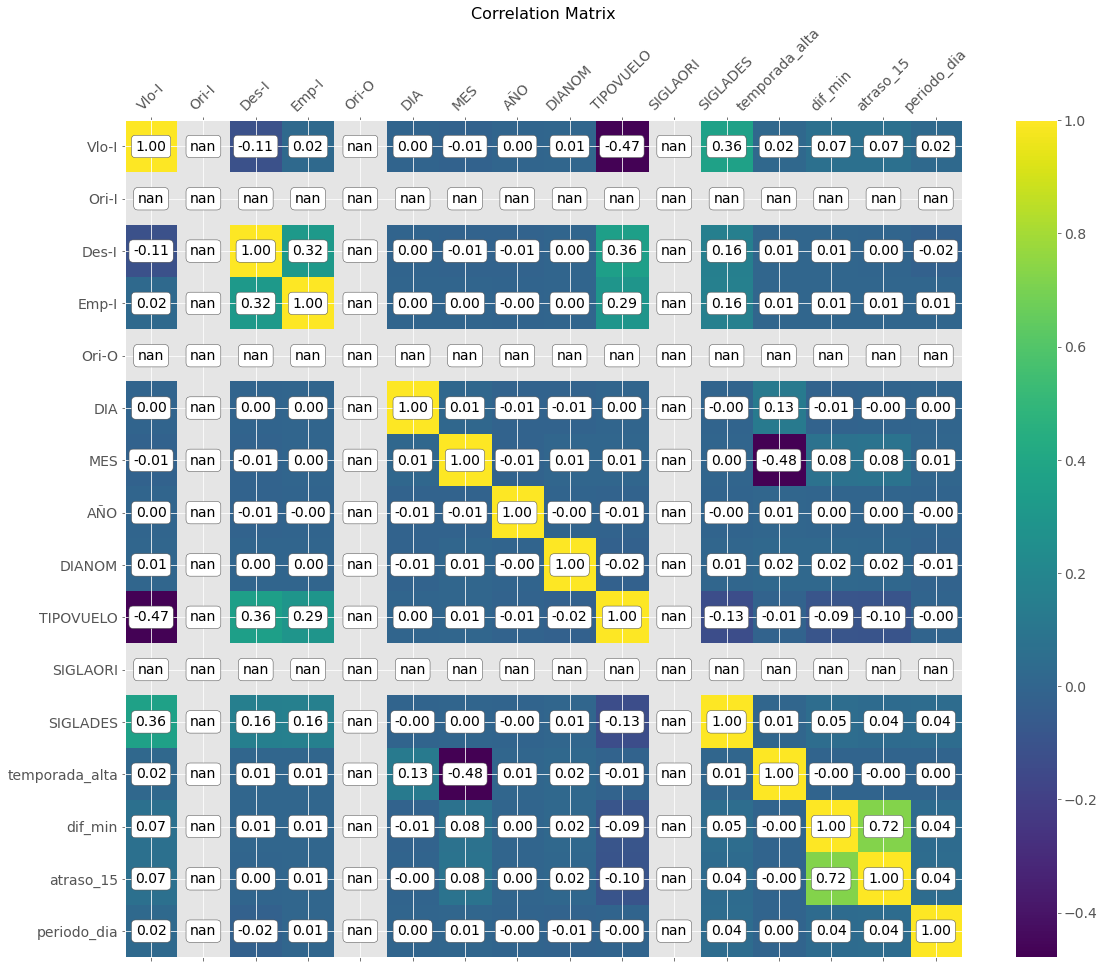

In [45]:
correlationgraph(allDataset)

In [46]:
allDataset.head()

,Vlo-I,Ori-I,Des-I,Emp-I,Ori-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,SIGLAORI,SIGLADES,temporada_alta,dif_min,atraso_15,periodo_dia
0,219,0,9,0,0,1,1,2017,0,0,0,34,1,3.0,0,1
1,219,0,9,0,0,2,1,2017,2,0,0,34,1,9.0,0,1
2,219,0,9,0,0,3,1,2017,3,0,0,34,1,9.0,0,1
3,219,0,9,0,0,4,1,2017,4,0,0,34,1,3.0,0,1
4,219,0,9,0,0,5,1,2017,1,0,0,34,1,0.0,0,1


In [47]:
allDataset['Probabilidad_Atraso'] = allDataset.progress_apply(probatraso, axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 68205/68205 [00:02<00:00, 30290.97it/s]


In [48]:
allDataset.drop('atraso_15', axis=1, inplace=True)
allDataset.drop('dif_min', axis=1, inplace=True)

In [49]:
TestModels = ["linear","Ridge","Lasso","BayesianRidge","SVM","Tree","RF","GBR","VR","KNN", "MLP"]

In [ ]:
modelraining(data = allDataset, modelos = TestModels, verbose = True)

linear r2_score: 0.03606710246693012
linear MAE: 34.28784188341331
linear MSE: 1500.9440635543297
linear MSLE: 4.89138480532471
linear MAPE: 5.645623064715422e+16
linear MedAE: 33.995010054401064
linear Max Error: 78.58476008150319
linear EVS: 0.03611821433038276
Saving model: Models/linear_PrData.pkl
-----------------------------------------------------------------------------

Ridge r2_score: 0.03606728224849487
Ridge MAE: 34.28790991804303
Ridge MSE: 1500.9437836156812
Ridge MSLE: 4.891408281827623
Ridge MAPE: 5.6456785436340856e+16
Ridge MedAE: 33.99592266848413
Ridge Max Error: 78.58519906410947
Ridge EVS: 0.03611850700816577
Saving model: Models/Ridge_PrData.pkl
-----------------------------------------------------------------------------

Lasso r2_score: 0.035886161841234276
Lasso MAE: 34.308649914203485
Lasso MSE: 1501.225806981376
Lasso MSLE: 4.894129528052727
Lasso MAPE: 5.648932821183182e+16
Lasso MedAE: 34.13647241090264
Lasso Max Error: 78.11226275635455
Lasso EVS: 0.03593